
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from agents.beacs import BEACS, BEACSConfiguration

# Load particular Environment Adapter
from my_examples.adapter.MountainCarEnvironmentAdapter import MountainCarEnvironmentAdapter

# Load Metrics
from my_examples.metrics.MountainCarMetrics import _mountaincar_metrics

# Load Plotting Wrappers
from my_examples.metrics.MountainCarPlottingWrapper import \
    parse_metrics_to_df, \
    plot_mountaincar_performance, \
    plot_average_mountaincar_performance

# Load environments
import gym

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
CLASSIFIER_LENGTH = 2
NUMBER_OF_POSSIBLE_ACTIONS = 3
MOUNTAINCAR = "MountainCar-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 10000
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
EPSILON = 1.0
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_RL = 100
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.
MUTATION = 0.

#BEACS Set Up
APPLY_CRACS = True
ENABLE_EP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 0

## Environment - MountainCar

In [3]:
# Initialize environment
MountainCar = gym.make(MOUNTAINCAR)
# To update the maximal number of step in a unique episode 
MountainCar._max_episode_steps = 1000
# Reset it, by putting an agent into random position
state = MountainCar.reset()

## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    environment_adapter=MountainCarEnvironmentAdapter,
    user_metrics_collector_fcn=_mountaincar_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_ep=ENABLE_EP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(MountainCar, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 2h 57min 26s, sys: 1min 40s, total: 2h 59min 6s
Wall time: 3h 4min 42s


### Performance

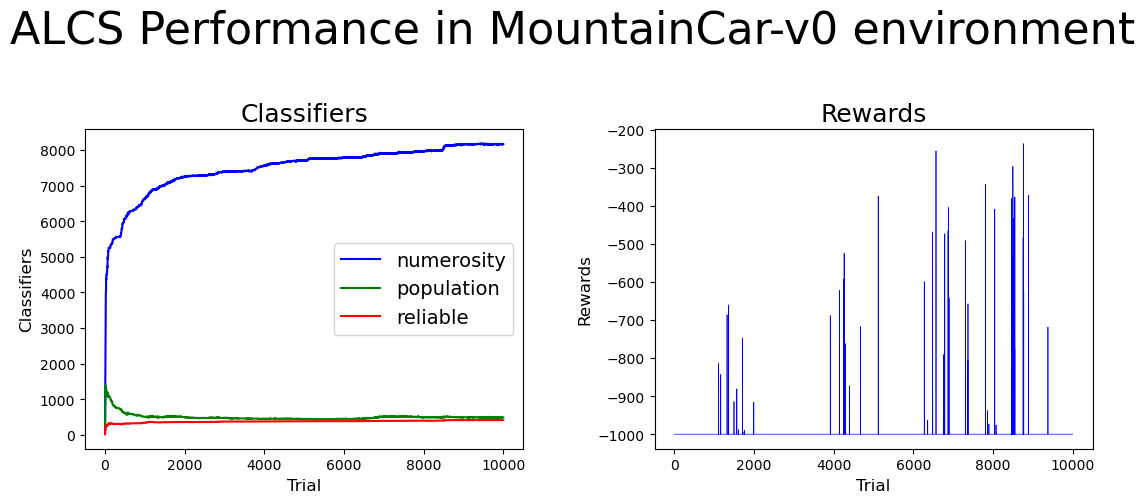

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None)
plot_mountaincar_performance(metrics_df, MOUNTAINCAR, metrics_trial_frequency_explore, None)

In [6]:
print(_mountaincar_metrics(population_explore, MountainCar))

if APPLY_CRACS:
    agent_explore.apply_cracs()
    population_explore = agent_explore.get_population()

print(_mountaincar_metrics(population_explore, MountainCar))

{'population': 495, 'numerosity': 8167, 'reliable': 420}
{'population': 444, 'numerosity': 8007, 'reliable': 407}


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
print(len(population_explore_to_display))
print("\n")
for cl in population_explore_to_display[:]:
    print(cl)
    print("\n")

444


C:5 1 A:2 None E:(4 2:1)
q: 0.5    ra: 0.0    rb: 0.0    ir: 0.0    f: 0.0    err: 0.0   
exp: 1     num: 1 ee: False
Mark: empty Can_be_generalized: [True, True] Aliased_state:  PAI_state: 
tga: 1495818 tbseq: 1495818 talp: 1495818 tav: 0.0    



C:4 1 A:2 None E:(3 2:1)
q: 0.5    ra: 0.0    rb: 0.0    ir: 0.0    f: 0.0    err: 0.0   
exp: 1     num: 1 ee: False
Mark: empty Can_be_generalized: [True, True] Aliased_state:  PAI_state: 
tga: 8546780 tbseq: 8546780 talp: 8546780 tav: 0.0    



C:# 1 A:1 None E:(# 2:1)
q: 0.5476 ra: -0.05329 rb: -0.4059 ir: -0.1426 f: -0.05329 err: 0.4202
exp: 4     num: 2 ee: True
Mark: 4 1 Can_be_generalized: [True, True] Aliased_state:  PAI_state: 
tga: 8519190 tbseq: 6428680 talp: 8519191 tav: 5.226e+05 



C:# 1 A:0 None E:(# 2:1)
q: 0.4501 ra: -0.1005 rb: -0.1461 ir: -0.2262 f: -0.1005 err: 0.1822
exp: 4     num: 1 ee: False
Mark: 4 1 Can_be_generalized: [True, True] Aliased_state:  PAI_state: 
tga: 8546779 tbseq: 5804277 talp: 8546779 tav: 6

In [8]:
agent_explore.get_pai_states_memory()

[]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_rl = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    environment_adapter=MountainCarEnvironmentAdapter,
    user_metrics_collector_fcn=_mountaincar_metrics,
    metrics_trial_frequency=1,
    do_ep=ENABLE_EP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.01,
    u_max=CLASSIFIER_LENGTH,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_explore)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(MountainCar, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 1min 18s, sys: 664 ms, total: 1min 18s
Wall time: 1min 19s


### Performance

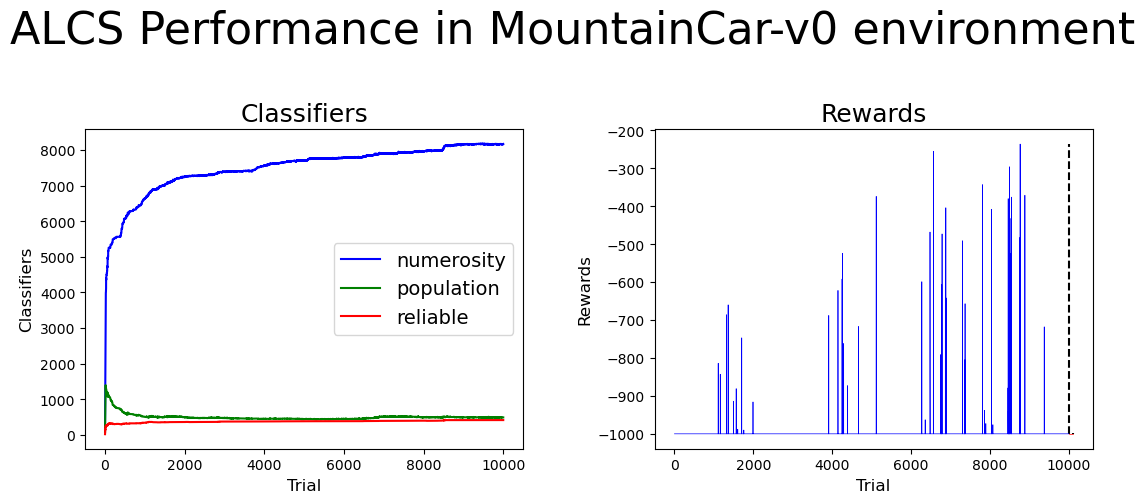

In [10]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit_rl)
plot_mountaincar_performance(metrics_df, MOUNTAINCAR, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_RL])

In [11]:
trials=[]

avg_step_explore = 0
for trial in metrics_explore:
    trials.append(trial['reward'])
    avg_step_explore += trial['reward']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of reward to solve the mountaincar is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

if NUMBER_OF_EXPLOIT_TRIALS_RL:
    avg_step_exploit_rl = 0
    for trial in metrics_exploit_rl:
        trials.append(trial['reward'])
        avg_step_exploit_rl += trial['reward']
    avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
    print("Average number of steps to solve the mountaincar is ",avg_step_exploit_rl,
          " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_mountaincar_metrics(population_explore, MountainCar))
print(_mountaincar_metrics(population_exploit_rl, MountainCar))

Average number of reward to solve the mountaincar is  -997.8405  for a total of  10000  trials in EXPLORATION
Average number of steps to solve the mountaincar is  -1000.0  for a total of  100  trials in EXPLOITATION with Reinforcement Module
{'population': 444, 'numerosity': 8007, 'reliable': 407}
{'population': 444, 'numerosity': 8007, 'reliable': 407}


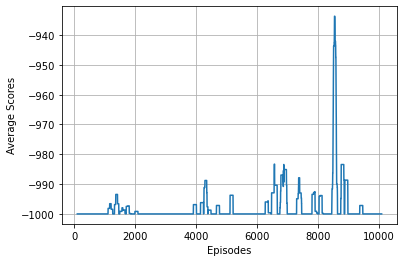

In [12]:
plot_average_mountaincar_performance(trials)

In [13]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.behavioral_sequence or cl.is_enhanced()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display[:50]:
    print(cl)
    print("\n")

411


C:10 15 A:0 None E:(# #:6, # 14:6)
q: 0.6853 ra: -0.4529 rb: -0.2898 ir: -0.6028 f: -0.2898 err: 0.3644
exp: 12    num: 3 ee: True
Mark: 10 15 Can_be_generalized: [True, False] Aliased_state: 1015 PAI_state: 
tga: 8865309 tbseq: 6769695 talp: 8865309 tav: 1.749e+05 



C:10 15 A:0 None E:(# #:6, # 14:6, 11 14:1)
q: 0.6853 ra: -0.4099 rb: -0.3368 ir: -0.6028 f: -0.3368 err: 0.2378
exp: 7     num: 4 ee: False
Mark: empty Can_be_generalized: [False, False] Aliased_state: 1015 PAI_state: 
tga: 8865309 tbseq: 7359470 talp: 8865309 tav: 2.292e+05 



C:11 14 A:0 None E:(# 13:5, # #:2)
q: 0.7311 ra: -0.4471 rb: -0.5012 ir: -0.708 f: -0.4471 err: 0.1756
exp: 6     num: 4 ee: False
Mark: empty Can_be_generalized: [True, False] Aliased_state: 1114 PAI_state: 
tga: 8865315 tbseq: 7359471 talp: 8865315 tav: 2.653e+05 



C:11 9 A:0 None E:(10 #:3, # #:8, 10 8:1)
q: 0.7778 ra: -0.6539 rb: -0.5598 ir: -0.7622 f: -0.5598 err: 0.06611
exp: 1     num: 1 ee: False
Mark: empty Can_be_generalized: [